# Tomato Disease Classification with VGG 16 and Neural Network

# Import Libraries

In [68]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from PIL import Image

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [69]:
import warnings
warnings.filterwarnings("ignore")

# Load Data

**Citation** 
<br />
Huang, Mei-Ling; Chang, Ya-Han (2020), “Dataset of Tomato Leaves”, Mendeley Data, 
<br />
V1, doi: 10.17632/ngdgg79rzb.1

In [70]:
os.chdir("/kaggle/input/dataset-of-tomato-leaves/plant_village")
print(os.listdir())

TRAINING_DIR = os.path.join('/kaggle/input/dataset-of-tomato-leaves/plant_village/train')
VALIDATION_DIR = os.path.join('/kaggle/input/dataset-of-tomato-leaves/plant_village/val')
TESTING_DIR = os.path.join('/kaggle/input/dataset-of-tomato-leaves/plant_village/test')

['val', 'test', 'train']


In [71]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [72]:
train_dataset = tf.keras.utils.image_dataset_from_directory(TRAINING_DIR,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 8715 files belonging to 10 classes.


In [73]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(VALIDATION_DIR,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2902 files belonging to 10 classes.


In [74]:
test_dataset = tf.keras.utils.image_dataset_from_directory(TESTING_DIR,
                                                           shuffle=False,
                                                           labels='inferred',
                                                           label_mode='categorical',
                                                           image_size=IMG_SIZE)

Found 2914 files belonging to 10 classes.


In [75]:
class_names = train_dataset.class_names
class_names

['Bacterial_spot',
 'Early_blight',
 'Healthy',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato_mosaic_virus',
 'Two_spotted_spider_mite']

# Visualize Training Data for each Class

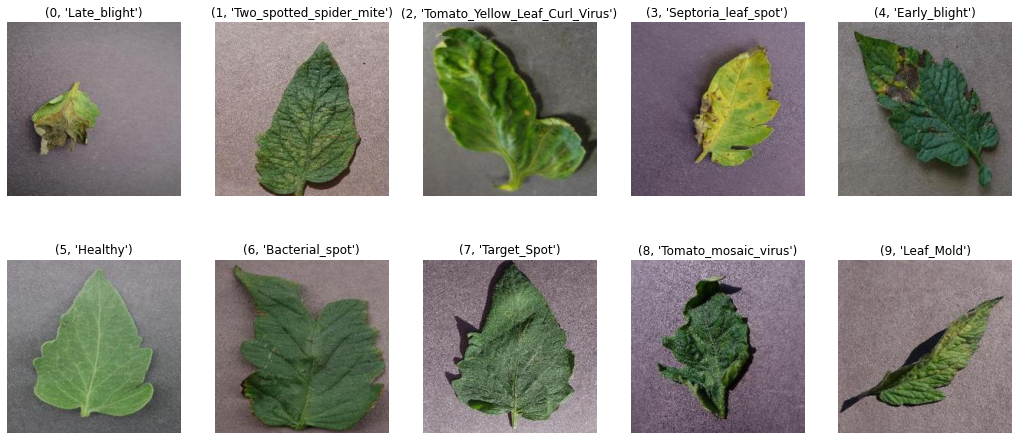

In [76]:
classes = os.listdir('./train')

plt.figure(figsize=(18,8))

for i in enumerate(classes):
    pic = os.listdir('./train/'+i[1])[0]
    image = Image.open('./train/'+i[1]+'/'+pic)
    image = np.asarray(image)
    plt.subplot(2, 5, i[0]+1)
    plt.title(i)
    plt.imshow(image)
    plt.axis("off")
plt.show()

# Data Summary

In [77]:
categories = []
train = []
val = []
test = []

folders = os.listdir('/kaggle/input/dataset-of-tomato-leaves/plant_village/train')
for f in folders:
    categories.append(f)
    train.append(len(os.listdir(os.path.join('/kaggle/input/dataset-of-tomato-leaves/plant_village/train', f))))

folders = os.listdir('/kaggle/input/dataset-of-tomato-leaves/plant_village/val')
for f in folders:
    val.append(len(os.listdir(os.path.join('/kaggle/input/dataset-of-tomato-leaves/plant_village/val', f))))

folders = os.listdir('/kaggle/input/dataset-of-tomato-leaves/plant_village/val')
for f in folders:
    test.append(len(os.listdir(os.path.join('/kaggle/input/dataset-of-tomato-leaves/plant_village/test', f))))

data_count = pd.DataFrame({'categories': categories,
                     'train': train,
                     'val': val,
                     'test': test                     
                    })

data_count

,categories,train,val,test
0,Late_blight,916,305,307
1,Two_spotted_spider_mite,804,268,269
2,Tomato_Yellow_Leaf_Curl_Virus,2571,857,858
3,Septoria_leaf_spot,850,283,284
4,Early_blight,480,160,160
5,Healthy,763,254,255
6,Bacterial_spot,1021,340,341
7,Target_Spot,674,224,226
8,Tomato_mosaic_virus,179,59,61
9,Leaf_Mold,457,152,153


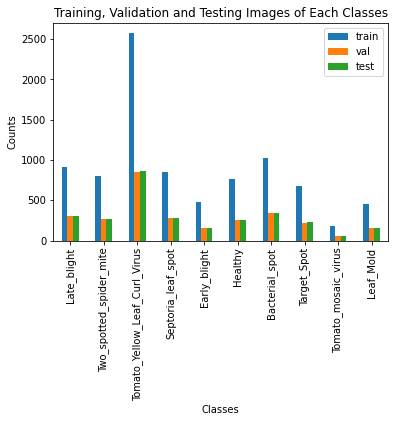

In [78]:
data_count.plot.bar(x='categories', title="Training, Validation and Testing Images of Each Classes")
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.show()

In [79]:
# Configure the dataset for performance
# Use buffered prefetching to load images from disk without having I/O become blocking.

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

In [80]:
def data_augmentation(x):
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(factor=0.2),
    ])(x)

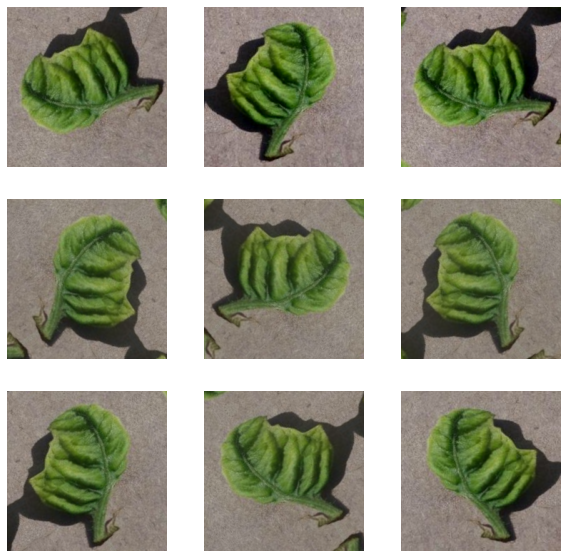

In [81]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Feature Extractor Base

In [82]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [83]:
base_model.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Utility Functions

In [84]:
def preprocess_input(x): 
    return tf.keras.layers.Rescaling(1./255, offset=-1)(x)


def feature_extractor(x):
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    return x


def classifier(x):
    x = tf.keras.layers.Dense(264, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(264, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x


def prediction_layer(x):
    return tf.keras.layers.Dense(10, activation='softmax')(x)

# Add Classification Head

In [85]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = feature_extractor(x)
x = classifier(x)

outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

# Compile the Model

In [86]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [87]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_29 (Sequential)   (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0   

In [88]:
initial_epochs = 10

In [89]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
273/273 [==============================] - 27s 95ms/step - loss: 2.0742 - accuracy: 0.2988 - val_loss: 1.8816 - val_accuracy: 0.4032
Epoch 2/10
273/273 [==============================] - 26s 95ms/step - loss: 1.8297 - accuracy: 0.3663 - val_loss: 1.5980 - val_accuracy: 0.5190
Epoch 3/10
273/273 [==============================] - 26s 95ms/step - loss: 1.6533 - accuracy: 0.4381 - val_loss: 1.4748 - val_accuracy: 0.5258
Epoch 4/10
273/273 [==============================] - 26s 95ms/step - loss: 1.5311 - accuracy: 0.4819 - val_loss: 1.3889 - val_accuracy: 0.5748
Epoch 5/10
273/273 [==============================] - 26s 95ms/step - loss: 1.4387 - accuracy: 0.5180 - val_loss: 1.3286 - val_accuracy: 0.5855
Epoch 6/10
273/273 [==============================] - 26s 94ms/step - loss: 1.3665 - accuracy: 0.5415 - val_loss: 1.2188 - val_accuracy: 0.6130
Epoch 7/10
273/273 [==============================] - 26s 95ms/step - loss: 1.2861 - accuracy: 0.5682 - val_loss: 1.1039 - val_accuracy:

# Plot Learning Curves

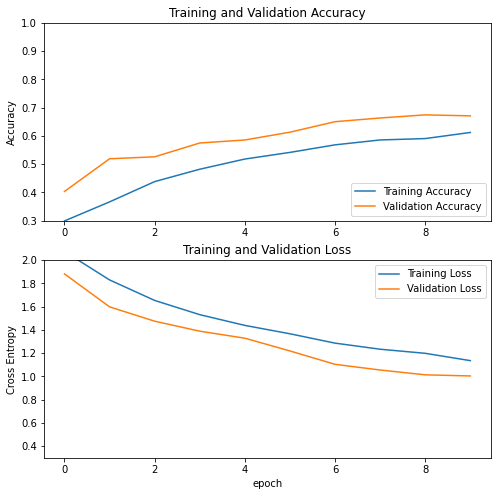

In [90]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.3,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0.3,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Unfreeeze Some Layers of Feature Extractor

In [91]:
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 10

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  19


# Compile the Model

In [92]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [93]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_29 (Sequential)   (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0   

# Continue Model Training

In [94]:
fine_tune_epochs = 40
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/50
273/273 [==============================] - 38s 132ms/step - loss: 0.8682 - accuracy: 0.6973 - val_loss: 0.8369 - val_accuracy: 0.7054
Epoch 11/50
273/273 [==============================] - 37s 133ms/step - loss: 0.6175 - accuracy: 0.7832 - val_loss: 0.5872 - val_accuracy: 0.7946
Epoch 12/50
273/273 [==============================] - 36s 131ms/step - loss: 0.4992 - accuracy: 0.8267 - val_loss: 0.5516 - val_accuracy: 0.8074
Epoch 13/50
273/273 [==============================] - 37s 133ms/step - loss: 0.4110 - accuracy: 0.8578 - val_loss: 0.3598 - val_accuracy: 0.8708
Epoch 14/50
273/273 [==============================] - 36s 131ms/step - loss: 0.3573 - accuracy: 0.8796 - val_loss: 0.3397 - val_accuracy: 0.8808
Epoch 15/50
273/273 [==============================] - 36s 132ms/step - loss: 0.3128 - accuracy: 0.8971 - val_loss: 0.2249 - val_accuracy: 0.9314
Epoch 16/50
273/273 [==============================] - 36s 132ms/step - loss: 0.2850 - accuracy: 0.9076 - val_loss: 0.3954 -

# Plot Learning Curve 

In [95]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

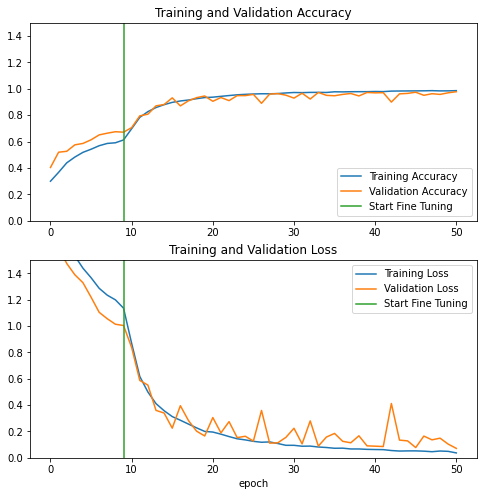

In [96]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1.5])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.5])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [97]:
CLASSES = []

folders = os.listdir(TESTING_DIR)
for f in folders:
    CLASSES.append(f)
    
CLASSES

['Late_blight',
 'Two_spotted_spider_mite',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Septoria_leaf_spot',
 'Early_blight',
 'Healthy',
 'Bacterial_spot',
 'Target_Spot',
 'Tomato_mosaic_virus',
 'Leaf_Mold']

# Prediction and Evaluation

In [98]:
predictions = np.array([])
labels =  np.array([])

for x, y in test_dataset:
    predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

Evaluating the Algorithm

Accuracy: 		 0.981811942347289
Precision: 		 0.981899425969745
Recall: 		 0.981811942347289
F1 score: 		 0.981811942347289 



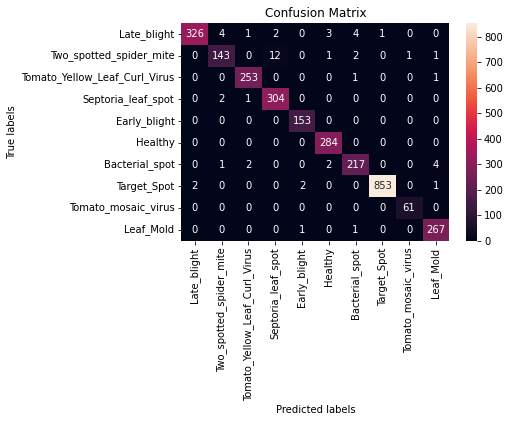

In [99]:
print('Evaluating the Algorithm\n')
print('Accuracy: \t\t', accuracy_score(labels, predictions))
print('Precision: \t\t', precision_score(labels, predictions, average='weighted'))
print('Recall: \t\t', recall_score(labels, predictions, average='weighted'))
print('F1 score: \t\t', f1_score(labels, predictions, average='micro'), '\n')

# Confusion Matrix
cf = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

ax= plt.subplot()
sns.heatmap(cf, annot=True, fmt='g', ax=ax);

ax.set_title('Confusion Matrix'); 

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 

ax.xaxis.set_ticklabels(CLASSES); 
ax.yaxis.set_ticklabels(CLASSES);

plt.xticks(rotation = 90)
plt.yticks(rotation = 360)

plt.show()

# Save the Model

In [100]:
os.chdir("/kaggle/working")

model.save('vgg16_NN')